In [1]:
from scipy import linalg
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import torchvision.utils as utils
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = datasets.CIFAR10(root="HW4/dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,shuffle=True, num_workers=2)
learning_rate = 5e-5
noise_dim =128
total_epochs = 50
weight_clip = 0.02
iter_real = next(iter(dataloader))

cuda
Files already downloaded and verified


In [4]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [12]:
class InceptionV3(nn.Module):
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }
    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)
        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()
        inception = models.inception_v3(pretrained=True)
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))
            if self.last_needed_block >= 2:
              block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))
        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)
        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break
        return outp


In [13]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    active=np.empty((len(images), dims))
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    predicted = model(batch)[0]
    if predicted.size(2) != 1 or predicted.size(3) != 1:
        predicted = adaptive_avg_pool2d(predicted, output_size=(1, 1))
    active= predicted.cpu().data.numpy().reshape(predicted.size(0), -1)    
    mean = np.mean(active, axis=0)
    sigma = np.cov(active, rowvar=False)
    return mean, sigma

In [14]:
def calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake, eps=1e-6):
    sigma_real = np.atleast_2d(sigma_real)
    sigma_fake = np.atleast_2d(sigma_fake)
    mu_real = np.atleast_1d(mu_real)
    mu_fake = np.atleast_1d(mu_fake)
    assert mu_real.shape == mu_fake.shape, \
        'Real and fake mean vectors have different lengths'
    assert sigma_real.shape == sigma_fake.shape, \
        'Real and fake covariances have different dimensions'
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('FID calculation produces singular product; '
               'adding {} to diagonal of cov estimates').format(eps)
        print(msg)
        offset = np.eye(sigma_real.shape[0]) * eps
        covmean = linalg.sqrtm((sigma_real + offset).dot(sigma_fake + offset))
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    tr_covmean = np.trace(covmean)
    return (diff.dot(diff) + np.trace(sigma_real) + np.trace(sigma_fake) - 2 * tr_covmean)

In [15]:
def calculate_fretchet(real_images, fake_images, model):
    mu_real, std_real = calculate_activation_statistics(real_images, model, cuda=True)
    mu_fake, std_fake = calculate_activation_statistics(fake_images, model, cuda=True)
    fd_value = calculate_frechet_distance(mu_real, std_real, mu_fake, std_fake)
    return fd_value

In [16]:
model = InceptionV3([InceptionV3.BLOCK_INDEX_BY_DIM[2048]])
model=model.cuda()

gen = Generator(noise_dim, channels_img = 3, features_g = 64).to(device)
critic = Discriminator(channels_img = 3, features_d = 64).to(device)

for m in gen.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
for m in critic.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)
step = 0

/home/pjujjav/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pjujjav/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
gen.train()
critic.train()

GLoss = []
DLoss = []
image_list = []
fd_list = []
i = 0


In [18]:
gen_optimizer = optim.RMSprop(gen.parameters(), lr = learning_rate)
critic_optimizer = optim.RMSprop(critic.parameters(), lr = learning_rate)

In [ ]:
for epoch in range(total_epochs):
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        cur_batch_size = data.shape[0]
        for _ in range(10): 
            noise = torch.randn(cur_batch_size, noise_dim, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            critic_optimizer.step()

            for p in critic.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{total_epochs}] Batch {batch_idx}/{len(loader)} \
                  Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f}"
            )
        GLoss.append(loss_gen.detach().cpu())
        DLoss.append(loss_critic.detach().cpu())
        if (i % 500 == 0) or ((epoch == total_epochs) and (batch_idx == len(loader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            image_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        i += 1
    fretchet_dist = calculate_fretchet(data, fake, model)
    fd_list.append(fretchet_dist)
    print('Fretchet Distance: ', fretchet_dist)

In [20]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define your transformations
transform = transforms.Compose([
    transforms.Resize(64),  # Resize the image to the desired size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

# Load the dataset (e.g., CIFAR-10)
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the DataLoader
batch_size = 64  # You can adjust this to your needs
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


100%|██████████| 170M/170M [00:04<00:00, 42.4MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


/home/pjujjav/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
for epoch in range(total_epochs):
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        cur_batch_size = data.shape[0]
        
        # Training loop for the critic (discriminator)
        for _ in range(10): 
            noise = torch.randn(cur_batch_size, noise_dim, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            critic_optimizer.step()

            for p in critic.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        # Generator training step
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{total_epochs}] Batch {batch_idx}/{len(loader)} "
                f"Loss Discriminator: {loss_critic:.3f}, Loss Generator: {loss_gen:.3f}"
            )
        
        GLoss.append(loss_gen.detach().cpu())
        DLoss.append(loss_critic.detach().cpu())

        if (batch_idx % 500 == 0) or ((epoch == total_epochs) and (batch_idx == len(loader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            image_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        i += 1

    fretchet_dist = calculate_fretchet(data, fake, model)
    fd_list.append(fretchet_dist)
    print('Fretchet Distance: ', fretchet_dist)


Epoch [0/50] Batch 0/782 Loss Discriminator: -0.552, Loss Generator: 0.457
Epoch [0/50] Batch 100/782 Loss Discriminator: -6.261, Loss Generator: 3.001
Epoch [0/50] Batch 200/782 Loss Discriminator: -6.283, Loss Generator: 3.010
Epoch [0/50] Batch 300/782 Loss Discriminator: -6.286, Loss Generator: 3.012
Epoch [0/50] Batch 400/782 Loss Discriminator: -6.187, Loss Generator: 3.012
Epoch [0/50] Batch 500/782 Loss Discriminator: -6.284, Loss Generator: 3.012
Epoch [0/50] Batch 600/782 Loss Discriminator: -6.278, Loss Generator: 3.009
Epoch [0/50] Batch 700/782 Loss Discriminator: -6.283, Loss Generator: 3.012
Fretchet Distance:  408.02962119420846
Epoch [1/50] Batch 0/782 Loss Discriminator: -6.284, Loss Generator: 3.012
Epoch [1/50] Batch 100/782 Loss Discriminator: -6.283, Loss Generator: 3.012
Epoch [1/50] Batch 200/782 Loss Discriminator: -6.274, Loss Generator: 3.007
Epoch [1/50] Batch 300/782 Loss Discriminator: -6.269, Loss Generator: 3.005
Epoch [1/50] Batch 400/782 Loss Discrimin

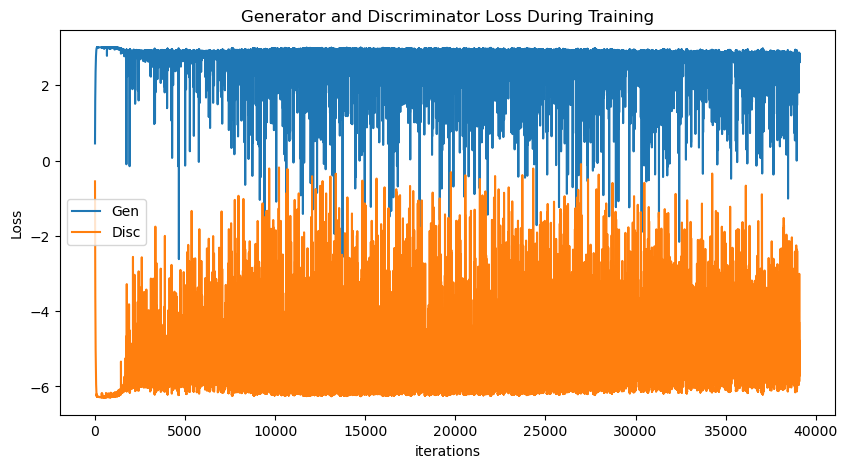

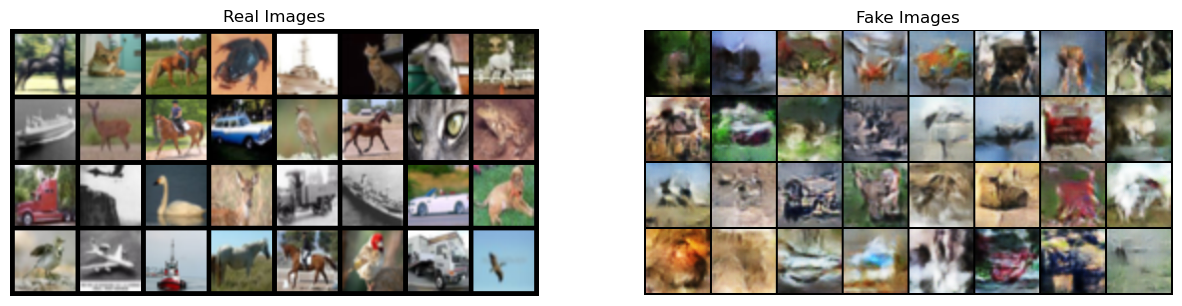

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GLoss,label="Gen")
plt.plot(DLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(iter_real[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(image_list[-1],(1,2,0)))
plt.savefig('compare.png')
plt.show()

In [23]:
print (gen)

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, 

In [ ]:
print (disc)

In [25]:
print (critic)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)
